<a href="https://colab.research.google.com/github/AkithaPasandul/Dengue-Outbreak-Prediction-Sri-lanka/blob/main/dengue_analysis_and_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imaport Libraries

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [142]:
dengue = pd.read_excel('/content/Dengue_Data (2010-2020).xlsx')
dengue.head()

,Date,City,Value
0,2010-01-01,Colombo,584
1,2010-02-01,Colombo,606
2,2010-03-01,Colombo,294
3,2010-04-01,Colombo,224
4,2010-05-01,Colombo,296


In [143]:
weather = pd.read_csv('/content/weather_cleaned.csv')
weather.head()

,district,date,temp_max_c,temp_min_c,temp_avg_c,daylight_seconds,rainfall_mm,rain_sum (mm),wind_speed,solar_radiation_mj_m2,evaporation_mm
0,Colombo,2010-01-01,30.1,22.6,26.0,42220.20,0.0,0.0,12.2,20.92,4.61
1,Colombo,2010-01-02,30.1,23.7,26.3,42225.71,0.1,0.1,13.0,17.71,3.91
2,Colombo,2010-01-03,29.6,23.1,26.0,42231.68,0.6,0.6,12.3,17.76,3.66
3,Colombo,2010-01-04,28.9,23.1,25.7,42238.11,0.0,0.0,17.0,16.50,3.75
4,Colombo,2010-01-05,28.1,21.3,24.6,42244.99,0.0,0.0,18.7,23.61,5.00


In [144]:
print("Dengue columns & rows:", dengue.shape)
print("Weather columns & rows:", weather.shape)

Dengue columns & rows: (3432, 3)
Weather columns & rows: (108486, 11)


# Data Prepocessing

Standardize & Aggregate

In [145]:
weather = weather.rename(columns={
    'city_name':'district',
    'temperature_2m_mean (°C)':'temp_avg_c',
    'precipitation_sum (mm)':'rainfall_mm'
})

In [146]:
weather['date'] = pd.to_datetime(weather['date'], errors='coerce').dt.to_period('M').dt.to_timestamp()
weather_m = weather.groupby(['district','date'], as_index=False).agg({
    'rainfall_mm':'sum',
    'temp_avg_c':'mean'
})

In [147]:
dengue = dengue.rename(columns={'Date':'date','City':'district','Value':'cases'})

In [148]:
dengue['date'] = pd.to_datetime(dengue['date']).dt.to_period('M').dt.to_timestamp()

In [149]:
dengue['district'] = dengue['district'].astype(str).str.strip().str.title()

In [150]:
dengue = dengue.groupby(['district','date'], as_index=False)['cases'].sum()

In [151]:
dengue.head()

,district,date,cases
0,Ampara,2010-01-01,12
1,Ampara,2010-02-01,13
2,Ampara,2010-03-01,25
3,Ampara,2010-04-01,19
4,Ampara,2010-05-01,9


In [152]:
weather_m.head()

,district,date,rainfall_mm,temp_avg_c
0,Ampara,2010-01-01,121.1,25.206452
1,Ampara,2010-02-01,30.7,25.778571
2,Ampara,2010-03-01,36.2,27.438710
3,Ampara,2010-04-01,76.0,28.300000
4,Ampara,2010-05-01,92.3,28.641935


Merge & Imputation

In [153]:
panel = pd.merge(dengue, weather_m, on=['district','date'], how='left').sort_values(['district','date'])

In [154]:
for c in ['rainfall_mm','temp_avg_c']:
    panel[c] = panel.groupby('district')[c].transform(lambda s: s.ffill().bfill())
    panel[c] = panel[c].fillna(panel[c].median())

In [155]:
panel.head()

,district,date,cases,rainfall_mm,temp_avg_c
0,Ampara,2010-01-01,12,121.1,25.206452
1,Ampara,2010-02-01,13,30.7,25.778571
2,Ampara,2010-03-01,25,36.2,27.438710
3,Ampara,2010-04-01,19,76.0,28.300000
4,Ampara,2010-05-01,9,92.3,28.641935


In [156]:
df = panel.copy()

# EDA

In [157]:
df.describe()

,date,cases,rainfall_mm,temp_avg_c
count,3432,3432.000000,3432.000000,3432.000000
mean,2015-06-16 19:38:10.909091072,188.107517,144.402448,26.354228
min,2010-01-01 00:00:00,0.000000,0.000000,20.270968
25%,2012-09-23 12:00:00,21.000000,103.000000,26.117742
50%,2015-06-16 00:00:00,58.000000,123.500000,26.316129
75%,2018-03-08 18:00:00,170.000000,147.725000,26.574812
max,2020-12-01 00:00:00,9039.000000,879.900000,30.806667
std,NaN,429.603007,106.553630,1.354878


In [158]:
df.shape

(3432, 5)

In [160]:
corelation = df.select_dtypes(include=np.number).corr()
corelation

,cases,rainfall_mm,temp_avg_c
cases,1.000000,0.150173,-0.030779
rainfall_mm,0.150173,1.000000,-0.365055
temp_avg_c,-0.030779,-0.365055,1.000000


<Axes: >

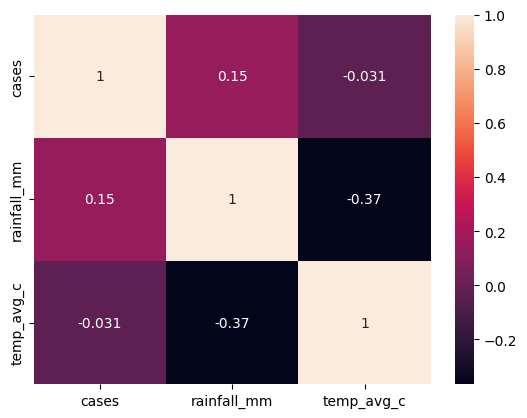

In [161]:
sns.heatmap(corelation, xticklabels=corelation.columns, yticklabels=corelation.columns, annot=True)

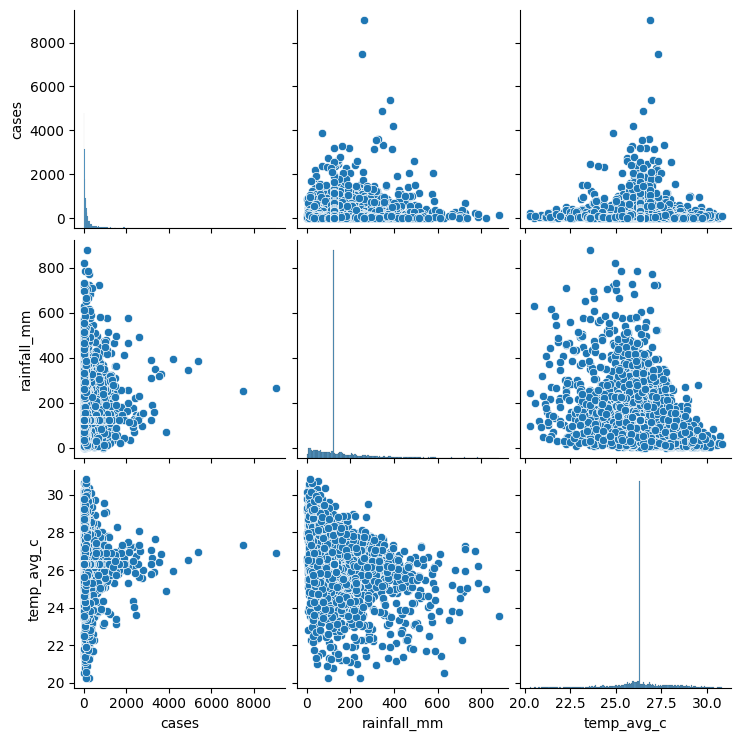

In [162]:
sns.pairplot(df)

Cases from 2010 to 2020

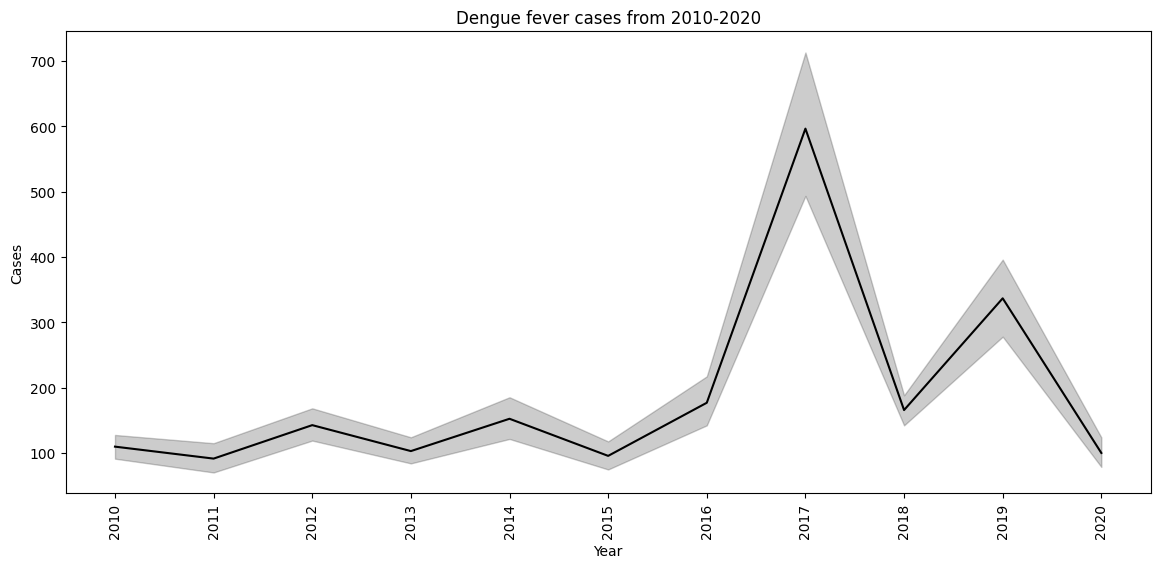

In [163]:
years = [f"{d.year}" for d in df['date']]
plt.figure(figsize=(14,6))
sns.lineplot(x=years,y=[i for i in df['cases']],color='black')
plt.title(label='Dengue fever cases from 2010-2020')
plt.xlabel(xlabel='Year')
plt.ylabel(ylabel='Cases')
plt.xticks(rotation=90)
plt.show()

### Analyze Relationship between Cases and Districts

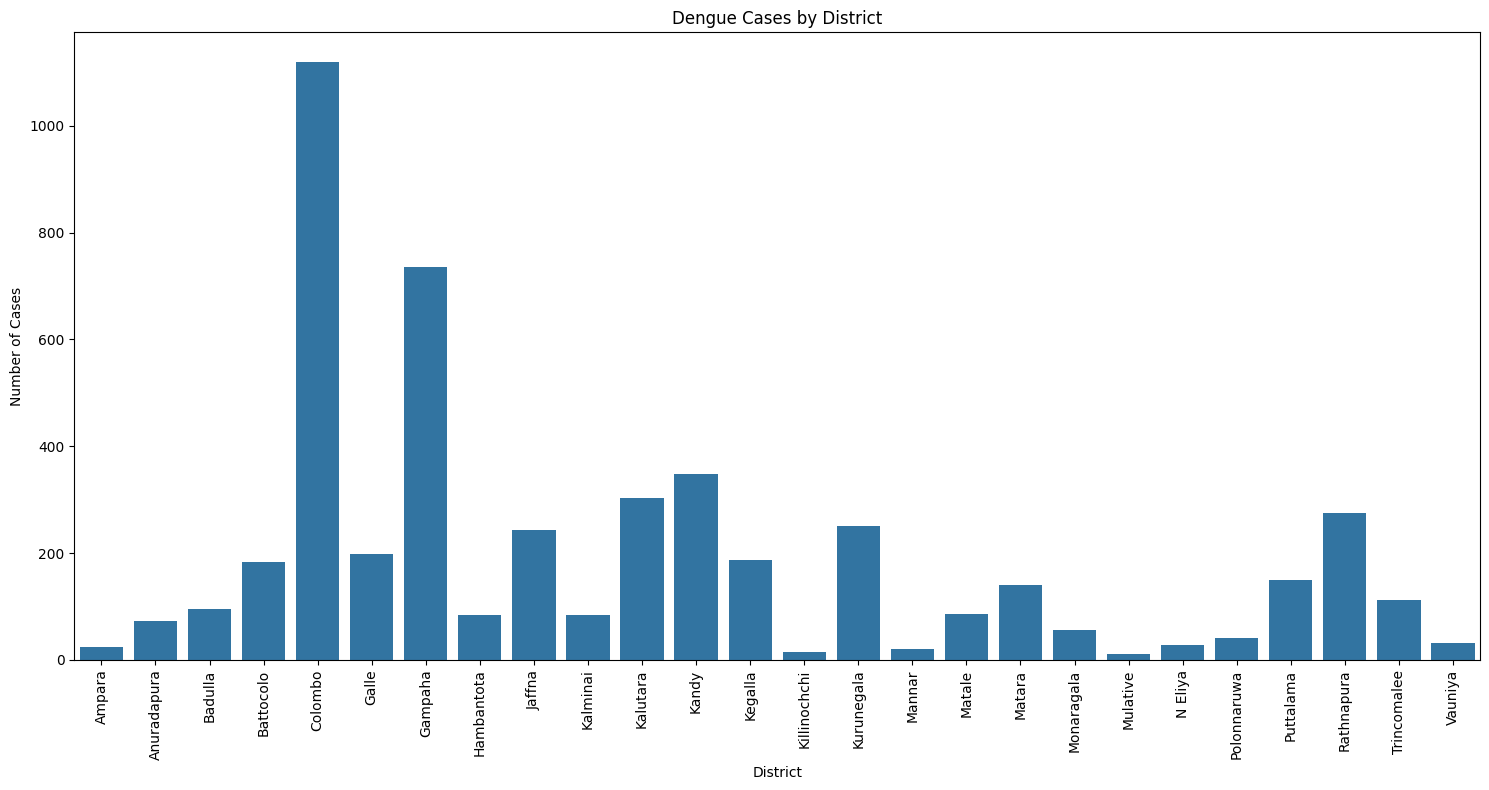

In [201]:
plt.figure(figsize=(15, 8))
sns.barplot(x='district', y='cases', data=df, ci=None)
plt.xticks(rotation=90)
plt.title('Dengue Cases by District')
plt.xlabel('District')
plt.ylabel('Number of Cases')
plt.tight_layout()
plt.show()

Top districts by median dengue cases: ['Colombo', 'Gampaha', 'Kandy']


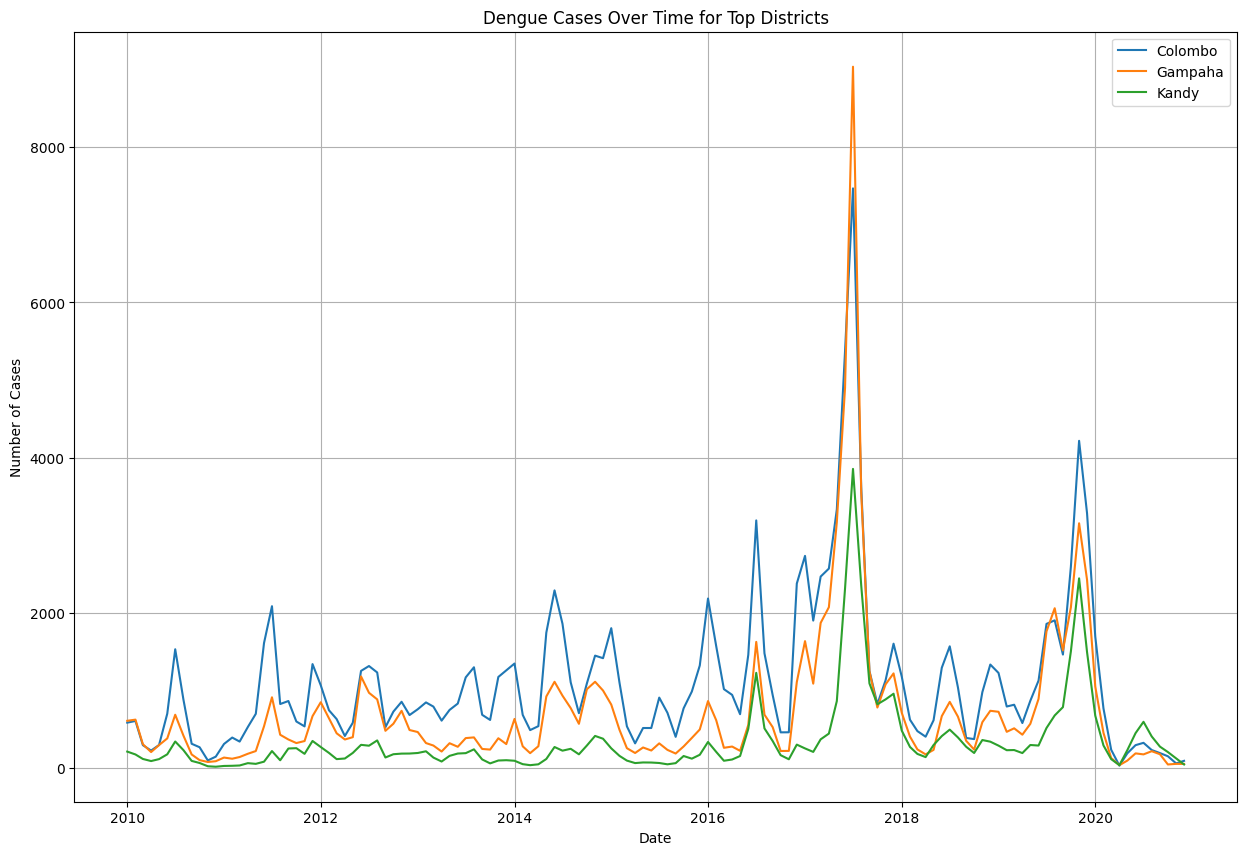

In [165]:
# Find the districts with the highest median cases
district_medians = df.groupby('district')['cases'].median().sort_values(ascending=False)
top_districts = district_medians.head(3).index.tolist()

print(f"Top districts by median dengue cases: {top_districts}")

# Plot time series for the top districts
plt.figure(figsize=(15, 10))
for district in top_districts:
    district_df = df[df['district'] == district]
    sns.lineplot(x='date', y='cases', data=district_df, label=district)

plt.title('Dengue Cases Over Time for Top Districts')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.show()

# Feature Engineering

In [166]:
def make_features(dengue_df, weather_df, max_lag=3, rolling_window=3):
    # Merge
    df = pd.merge(dengue_df, weather_df, on=['date','district'], how='left')
    df.sort_values(['district','date'], inplace=True)

    # Time-based features
    df['month'] = df['date'].dt.month
    df['sin_month'] = np.sin(2*np.pi*df['month']/12)
    df['cos_month'] = np.cos(2*np.pi*df['month']/12)

    # Lag features for target and key weather variables
    for lag in range(1, max_lag+1):
        df[f'cases_lag{lag}'] = df.groupby('district')['cases'].shift(lag)
        df[f'rain_lag{lag}'] = df.groupby('district')['rainfall_mm'].shift(lag)
        df[f'temp_lag{lag}'] = df.groupby('district')['temp_avg_c'].shift(lag)

    # Rolling statistics (on rainfall as an example)
    df['rain_roll_mean'] = df.groupby('district')['rainfall_mm'].transform(lambda s: s.rolling(rolling_window).mean())
    df['rain_roll_std']  = df.groupby('district')['rainfall_mm'].transform(lambda s: s.rolling(rolling_window).std())

    df.dropna(inplace=True)
    return df

panel = make_features(dengue, weather_m, max_lag=3, rolling_window=3)
feature_cols = [c for c in panel.columns if c not in ['cases','date','district']]
target_col = 'cases'  # for regression
print('Feature columns:', feature_cols[:10], '... (total:', len(feature_cols), ')')
panel.head()

Feature columns: ['rainfall_mm', 'temp_avg_c', 'month', 'sin_month', 'cos_month', 'cases_lag1', 'rain_lag1', 'temp_lag1', 'cases_lag2', 'rain_lag2'] ... (total: 16 )


,district,date,cases,rainfall_mm,temp_avg_c,month,sin_month,cos_month,cases_lag1,rain_lag1,temp_lag1,cases_lag2,rain_lag2,temp_lag2,cases_lag3,rain_lag3,temp_lag3,rain_roll_mean,rain_roll_std
3,Ampara,2010-04-01,19,76.0,28.300000,4,8.660254e-01,-0.500000,25.0,36.2,27.438710,13.0,30.7,25.778571,12.0,121.1,25.206452,47.633333,24.719695
4,Ampara,2010-05-01,9,92.3,28.641935,5,5.000000e-01,-0.866025,19.0,76.0,28.300000,25.0,36.2,27.438710,13.0,30.7,25.778571,68.166667,28.858679
5,Ampara,2010-06-01,6,97.0,28.843333,6,1.224647e-16,-1.000000,9.0,92.3,28.641935,19.0,76.0,28.300000,25.0,36.2,27.438710,88.433333,11.021040
6,Ampara,2010-07-01,30,43.1,28.867742,7,-5.000000e-01,-0.866025,6.0,97.0,28.843333,9.0,92.3,28.641935,19.0,76.0,28.300000,77.466667,29.855039
7,Ampara,2010-08-01,21,133.1,28.603226,8,-8.660254e-01,-0.500000,30.0,43.1,28.867742,6.0,97.0,28.843333,9.0,92.3,28.641935,91.066667,45.292420


# Model

## Baseline Model

In [167]:
def naive_last_month(df):
    df = df.copy()
    df['y_hat'] = df.groupby('district')['cases'].shift(1)
    return df

In [168]:
def moving_average(df, window=3):
    df = df.copy()
    df['y_hat'] = df.groupby('district')['cases'].shift(1).rolling(window).mean()
    return df

In [169]:
baseline_df = naive_last_month(panel)
baseline_df = baseline_df.dropna(subset=['y_hat'])

In [170]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [171]:
print('Baseline MAE:', mae(baseline_df['cases'].values, baseline_df['y_hat'].values))

Baseline MAE: 114.1484375


##Regression Model

In [172]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import math

In [173]:
cutoff_date = panel['date'].quantile(0.8)
train = panel[panel['date'] <= cutoff_date]
test  = panel[panel['date'] >  cutoff_date]

In [174]:
X_train, y_train = train[feature_cols], train[target_col]
X_test,  y_test  = test[feature_cols],  test[target_col]

In [175]:
RANDOM_SEED = 42

In [176]:
reg = RandomForestRegressor(n_estimators=400, max_depth=10, random_state=RANDOM_SEED, n_jobs=-1)
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=400, n_jobs=-1,
                      random_state=42)

In [177]:
pred = reg.predict(X_test)

In [178]:
rmse = math.sqrt(mean_squared_error(y_test, pred))
mae_ = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)
print(f'Regression — RMSE: {rmse:.2f} | MAE: {mae_:.2f} | R²: {r2:.3f}')

Regression — RMSE: 231.06 | MAE: 106.89 | R²: 0.822


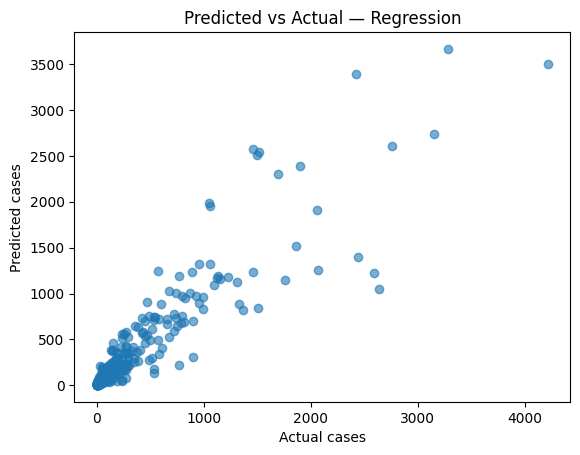

In [179]:
# Predicted vs Actual (Regression)
plt.figure()
plt.scatter(y_test, pred, alpha=0.6)
plt.xlabel('Actual cases')
plt.ylabel('Predicted cases')
plt.title('Predicted vs Actual — Regression')
plt.show()

## Classification Model

In [180]:
def make_outbreak_label(df, pct=0.85):
    df = df.copy()
    thr = df.groupby('district')['cases'].transform(lambda s: s.quantile(pct))
    df['outbreak'] = (df['cases'] >= thr).astype(int)
    return df

In [181]:
clf_df = make_outbreak_label(panel, pct=0.85)
train_c = clf_df[clf_df['date'] <= cutoff_date]
test_c  = clf_df[clf_df['date'] >  cutoff_date]

In [182]:
clf = RandomForestClassifier(n_estimators=400, random_state=RANDOM_SEED, n_jobs=-1)
clf.fit(train_c[feature_cols], train_c['outbreak'])

RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)

In [183]:
proba = clf.predict_proba(test_c[feature_cols])[:,1]
pred_c = (proba >= 0.5).astype(int)

In [184]:
roc = roc_auc_score(test_c['outbreak'], proba)
f1  = f1_score(test_c['outbreak'], pred_c)
prec= precision_score(test_c['outbreak'], pred_c)
rec = recall_score(test_c['outbreak'], pred_c)
print(f'Classification — ROC-AUC: {roc:.3f} | F1: {f1:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f}')

Classification — ROC-AUC: 0.797 | F1: 0.390 | Precision: 0.750 | Recall: 0.264


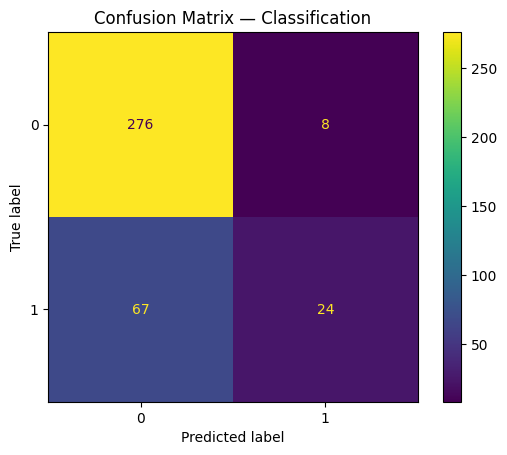

In [185]:
# Confusion Matrix
cm = confusion_matrix(test_c['outbreak'], pred_c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix — Classification')
plt.show()

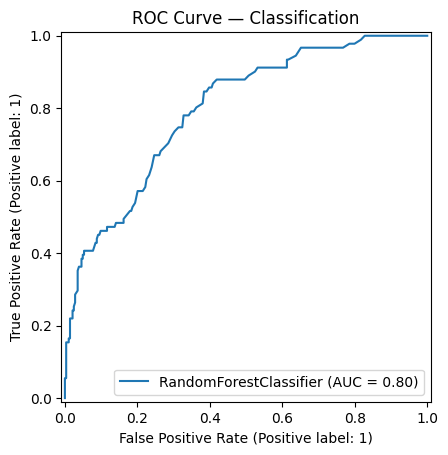

In [186]:
# ROC Curve
RocCurveDisplay.from_estimator(clf, test_c[feature_cols], test_c['outbreak'])
plt.title('ROC Curve — Classification')
plt.show()

# Time Series Analysis

In [187]:
panel['date'] = pd.to_datetime(panel['date'])

In [188]:
old_df = (panel.groupby('date', as_index=False).agg({'cases': 'sum'}).sort_values('date'))
old_df.head()

,date,cases
0,2010-04-01,1258
1,2010-05-01,1416
2,2010-06-01,2546
3,2010-07-01,4783
4,2010-08-01,3135


In [189]:
new_df = pd.read_excel('/content/dengue_2020_2025.xlsx')
new_df.head()

,date,cases
0,2021-01-01,1496
1,2021-02-01,1794
2,2021-03-01,849
3,2021-04-01,1702
4,2021-05-01,137


In [190]:
country_df = pd.concat([old_df, new_df], ignore_index=True)

In [191]:
# extract mountly cases
country_df = country_df.set_index('date')
monthly_cases = country_df.resample('ME').sum()
monthly_cases.head()

,cases
date,
2010-04-30,1258
2010-05-31,1416
2010-06-30,2546
2010-07-31,4783
2010-08-31,3135


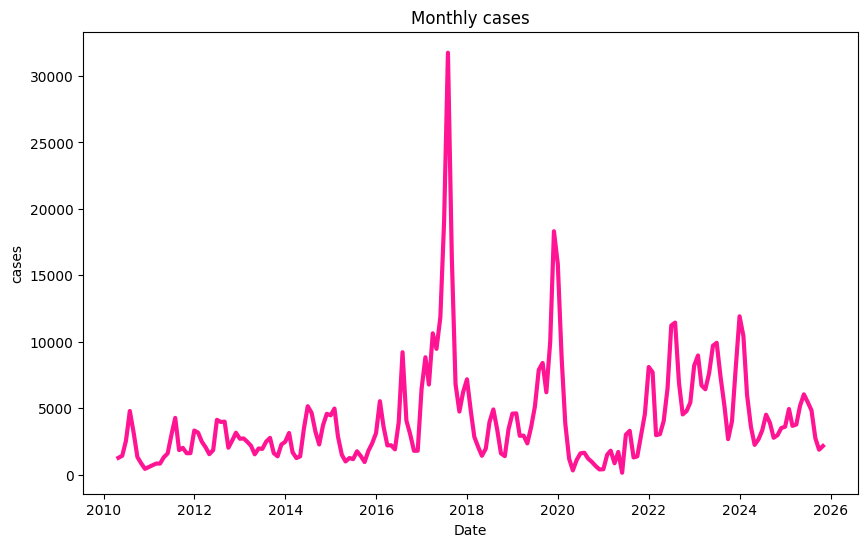

In [192]:
# ploting montly cases
plt.figure(figsize=(10, 6))
plt.plot(monthly_cases['cases'], linewidth=3, c='deeppink')
plt.title("Monthly cases")
plt.xlabel("Date")
plt.ylabel("cases")
plt.show()

In [193]:
# check stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')


check_stationarity(monthly_cases['cases'])

ADF Statistic: -3.7137264827574326
p-value: 0.00392416967501832
Stationary


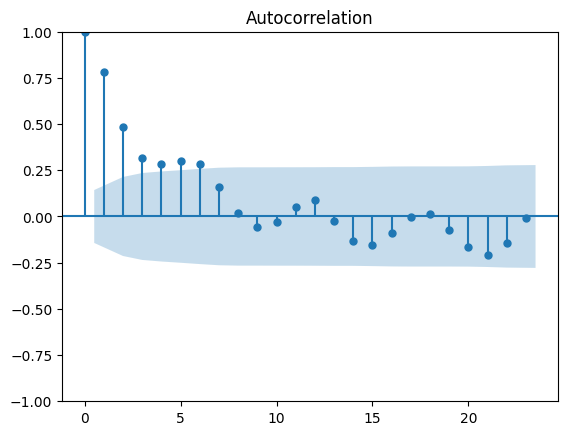

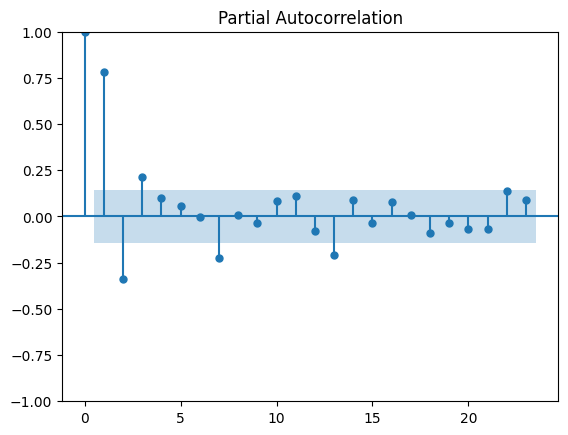

In [194]:
# ACF and PACF plots
plot_acf(monthly_cases)
plot_pacf(monthly_cases)
plt.show()

In [195]:
auto_model = pm.auto_arima(
    monthly_cases,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    seasonal=True,
    m=12,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    trace=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

print(auto_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  187
Model:             SARIMAX(2, 1, 1)x(0, 0, [1, 2], 12)   Log Likelihood               -1694.960
Date:                                 Wed, 29 Oct 2025   AIC                           3401.921
Time:                                         08:26:39   BIC                           3421.275
Sample:                                     04-30-2010   HQIC                          3409.764
                                          - 10-31-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6980      0.192      3.641      0.000       0.322       1

In [196]:
model = SARIMAX(monthly_cases, order=(2, 1, 1), seasonal_order=(0, 0, [1, 2], 12))
results = model.fit()

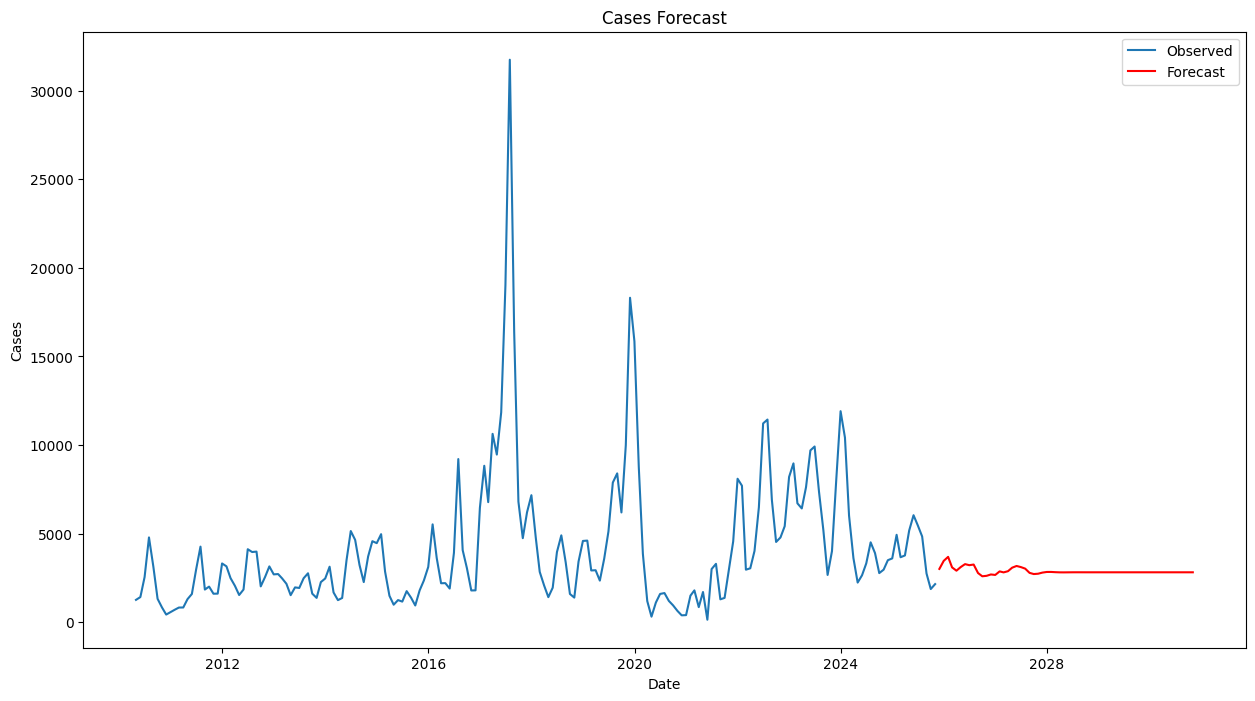

In [197]:
# Forecasting
forecast_periods = 60
forecast = results.forecast(steps=forecast_periods)

plt.figure(figsize=(15, 8))
plt.plot(monthly_cases, label='Observed')
plt.plot(forecast, label='Forecast', color='red')
plt.title("Cases Forecast")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.show()

In [198]:
observed = monthly_cases[-forecast_periods:]
mae = mean_absolute_error(observed, forecast)
mse = mean_squared_error(observed, forecast)
print(f'MAE: {mae}')
print(f'MSE: {mse}')

MAE: 2606.583625634506
MSE: 12341803.043733304


# Evaluation

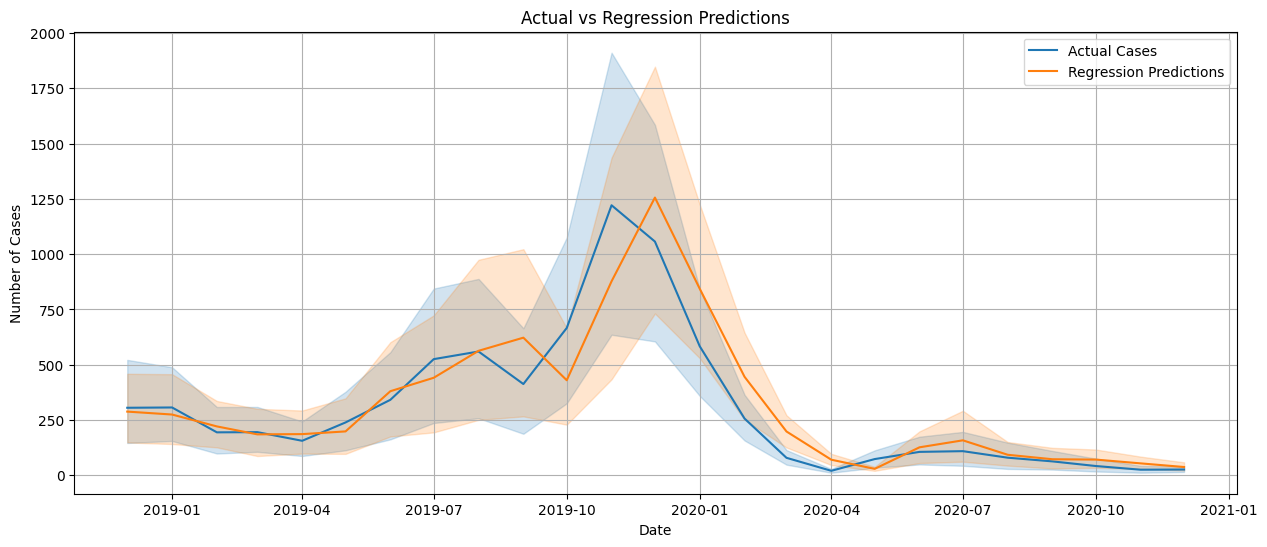

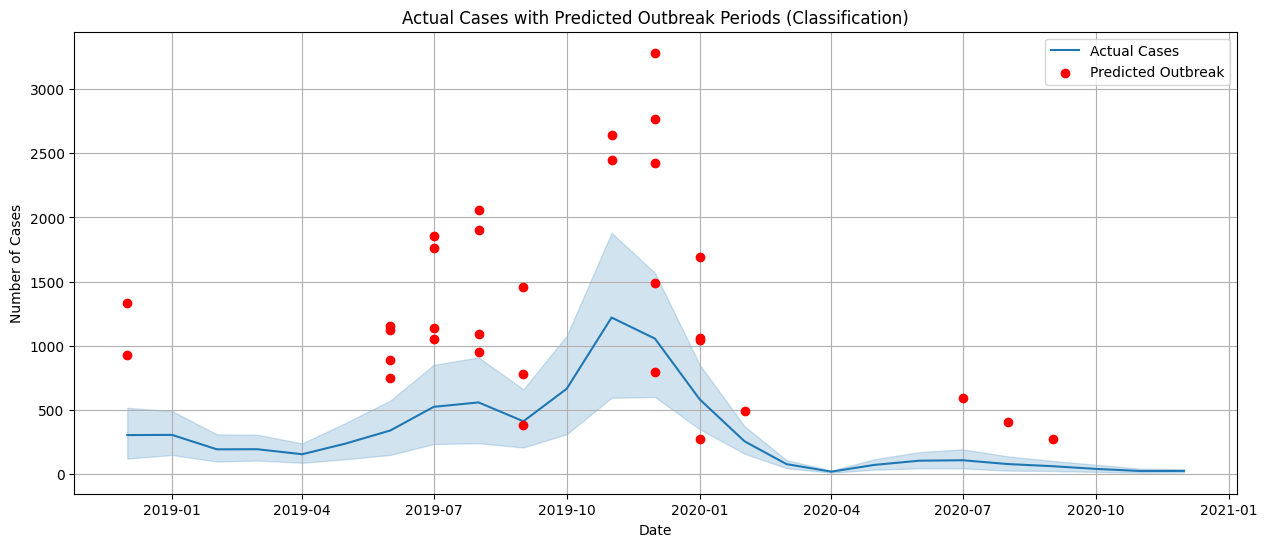

In [199]:
# Combine test data with predictions for plotting
test_combined = test.copy()
test_combined['regression_pred'] = pred
test_combined['classification_pred_proba'] = proba
test_combined['classification_pred_class'] = pred_c

# Sort by date for plotting
test_combined.sort_values('date', inplace=True)

# Actual vs Regression Predictions
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='cases', data=test_combined, label='Actual Cases')
sns.lineplot(x='date', y='regression_pred', data=test_combined, label='Regression Predictions')
plt.title('Actual vs Regression Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.show()

# Actual Cases with Classification Predictions
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='cases', data=test_combined, label='Actual Cases')
outbreak_dates = test_combined[test_combined['classification_pred_class'] == 1]['date']
outbreak_cases = test_combined[test_combined['classification_pred_class'] == 1]['cases']
plt.scatter(outbreak_dates, outbreak_cases, color='red', label='Predicted Outbreak', zorder=5)
plt.title('Actual Cases with Predicted Outbreak Periods (Classification)')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.show()

SHAP example for the trained RandomForest regressor

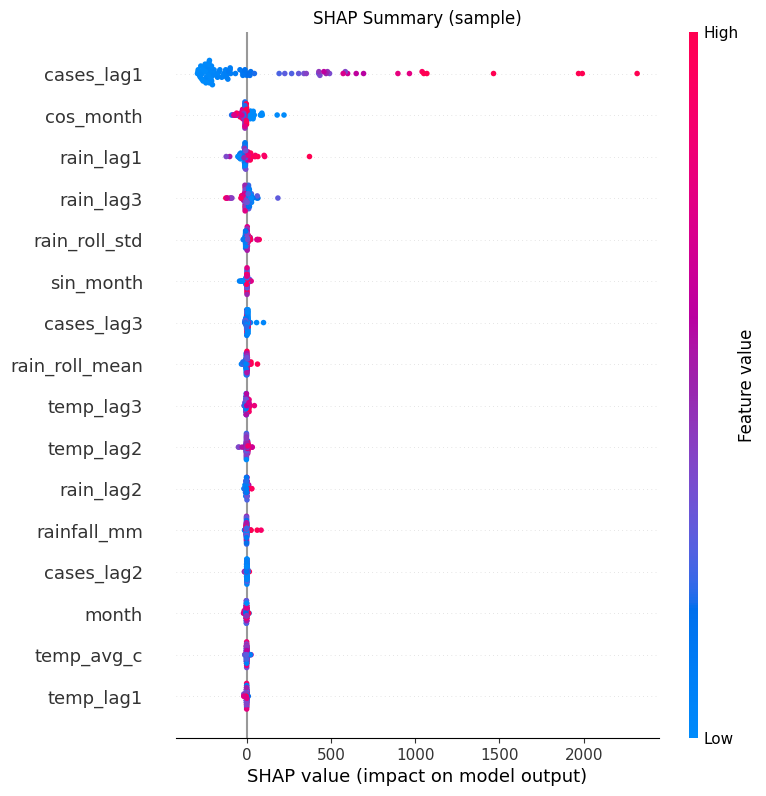

In [200]:
try:
    import shap
    explainer = shap.TreeExplainer(reg)
    shap_values = explainer.shap_values(X_test.sample(min(100, len(X_test)), random_state=RANDOM_SEED))
    shap.summary_plot(shap_values, X_test.sample(min(100, len(X_test)), random_state=RANDOM_SEED), show=False)
    plt.title('SHAP Summary (sample)')
    plt.show()
except Exception as e:
    print('SHAP not available or failed:', e)